In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%reload_ext autoreload
%autoreload 2

# The shallow water wave equations

<hr style="border-width:4px; border-color:coral"></hr>

The shallow water wave equations are ...

For the wave propagation algorithm, we need to define a Riemann solver that can solve for "wave", "speeds" and fluctuations.  Before we can do this, however, you have to have a basic understanding of the structure of the wave equation. The problem below should give you the understanding needed to write the Riemann solver for the WPA. 


## The shallow water wave equations
<hr style="border-width:4px; border-color:coral"></hr>

*TODO* : Modify this text to include model description of shallow water wave equations.


The two-way wave equation can be used to model acoustic waves (e.g. sound waves or pressure waves) in air.  In this case, the wave equation is written in terms of pressure $p(x,t)$ ($N/m^2$) and is given by 

\begin{equation}
p_{tt} = c^2 p_{xx} = 0, \qquad -\infty < x < \infty
\end{equation}

where $c$ ($m/s$) is the speed of sound in the air.  A second quantity $u(x,t)$ ($m/s$) is the velocity of a parcel of air as it is perturbed by the pressure wave. 

A model for both the pressure and velocity can be written as a system of first order equations (e.g. containing first derivatives only), given by

\begin{eqnarray}
p_t + \rho c^2 u_x & = & 0 \\
\rho u_t + p_x & = & 0
\end{eqnarray}

where $\rho$ ($kg/m^3$) is the constant density of air.  This can be written as a *quasi-linear* system

\begin{equation}
\begin{pmatrix} p \\ u \end{pmatrix}_t + 
\begin{pmatrix} 0 &  \rho c^2 \\ \frac{1}{\rho} & 0 \end{pmatrix} 
\begin{pmatrix} p \\ u \end{pmatrix}_x =  
\begin{pmatrix} 0 \\ 0 \end{pmatrix}
\end{equation}

or more generally as
\begin{equation}
\mathbf q_t + A \mathbf q_x = 0
\end{equation}

where $\mathbf q(x,t) = (p(x,t), u(x,t))$ and $A$ is the $2 \times 2$ matrix

\begin{equation}
A = \begin{pmatrix} 0 &  \rho c^2 \\ \frac{1}{\rho} & 0 \end{pmatrix}.
\end{equation}


Analytically, we can solve this system in the following steps. 

## Problem : Dam break problem
<hr style="border-width:4px; border-color:coral"></hr>

Do the dam break problem on page 259.  

* Domain $[-5,5]$
* Final time $T=2$. 

1. Consider an initial velocity $u(x,0) = 0$, and an initial height field given by

\begin{equation*}
h(x,0) = \left\{\begin{array}{rr} 
1 & x < 0 \\
2 & x >= 0\\
\end{array}
\right.
\end{equation*}

Set $g = 1$ and plot the solution for $h(x,t)$ and $hu$ at time $t = 2$.  


In [7]:
# Global data needed for Riemann solver and initialization routine

# sound speed and  density
c = 1
rho = 1

def rp1_wave(Q_ext):
    """  Input : 
            Q_ext : Array of N+4 Q values.   Boundary conditions are included.
            
        Output : 
            waves  : Jump in Q at edges -3/2, -1/2, ..., N-1/2, N+1/2 (N+3 values total)
            speeds : Array of speeds (N+3 values)
            apdq   : Positive fluctuations (N+3 values)
            amdq   : Negative fluctuations (N+3 values)
        """    
        
    # This Riemann solver solves two-way wave equation.
        
        
    # jump in Q at each interface
    delta = Q_ext[1:,:]-Q_ext[:-1,:]
    
    # For most problems, the number of waves is equal to the number of equations
    mwaves = meqn

    # Matrix of eigenvalues  ()
    R = array([[1,0],[0,1]])      # TODO : Update for wave equation
    
    # Vector of eigenvalues
    evals =  array([1,1])         # TODO : Update for wave equation
    
    d0 = delta[:,[0]]
    d1 = delta[:,[1]]
    
    # Solve R*alpha = delta to get a1=alpha[0], a2=alpha[1]
    # Should be in terms of d0, d1
    a1 = d0    # TODO : Update
    a2 = d1
        
    # Wave and speed 1
    w1 = a1@R[:,[0]].T
    s1 = evals[0]

    # Wave and speed 2
    w2 = a2@R[:,[1]].T
    s2 = evals[1]
    
    z = ones((delta.shape[0],1))
    waves = (w1,w2)             # P^th wave at each interface
    speeds = (s1*z,s2*z)   # Speeds at each interface
                
    # Fluctuations
    amdq = zeros(delta.shape)
    apdq = zeros(delta.shape)
    for mw in range(mwaves):
        sm = where(speeds[mw] < 0, speeds[mw], 0)
        amdq += sm*waves[mw]
        
        sp = where(speeds[mw] > 0, speeds[mw], 0)
        apdq += sp*waves[mw]
    
    return waves,speeds,amdq,apdq

## Boundary conditions

The boundary conditions can be determined in a variety of ways.  Below, we prescribe
periodic boundary conditions. 

In [8]:
def bc_extrap(Q):
    """ Extend Q with extrapolation boundary conditions """
        
    Q_ext = concatenate((Q[[1,0],:], Q, Q[[-1,-2],:]))
    return Q_ext

## Initial conditions

The solver should supply an initialization routine to initialize  q(x,t)  at time  t=0 .

The exact solution is also supplied here, since it depends on the initial conditions.

In [9]:
def uinit(x):
    
    q0 = where(logical_and(-1 < x, x < 0),-1,0) +  where(logical_and(0 < x, x < 1),1,0)  # u(x,t)        
    return q0

def pinit(x):
    
    q0 = zeros(x.shape)
    
    return q0

# this relies on velocity u set above.
def qexact(x,t,meqn):
    
    q = zeros((x.shape[0],meqn))
    q[:,0] =  -rho*c*(uinit(x+c*t) - uinit(x-c*t))/2  # Pressure
    q[:,1] =         (uinit(x-c*t) + uinit(x+c*t))/2  # velocity
    
    return q

def qinit(x,meqn):
    return qexact(x,0,meqn)


## Problem test

Below, we solve the scalar advection equation on the domain $[0,1]$ using periodic boundary conditions.  

In [10]:
# Spatial domain
ax = -5
bx = 5
meqn = 2  # Number of equations in the system

# Temporal domain
Tfinal = 2

# Numerical parameters
cfl = 0.8

## Sample test and plot

In [11]:
import wpa

mx = 256

# Compute maximum wave speed over the msh
umax = 2    # Constant for scalar advection (set above in Riemann solver)
    
# Estimate time step and number of time steps to take
dx = (bx-ax)/mx
dt_est = cfl*dx/umax;
nout = int(floor(Tfinal/dt_est) + 1)
dt = Tfinal/nout
        
Q,xc,tvec = wpa.claw1(ax,bx, mx,  Tfinal, nout, \
                      meqn=meqn, \
                      rp=rp1_wave, \
                      qinit=qinit, \
                      bc=bc_extrap, \
                      limiter_choice='MC',
                      second_order=True)

## Plot the solution

<IPython.core.display.Javascript object>


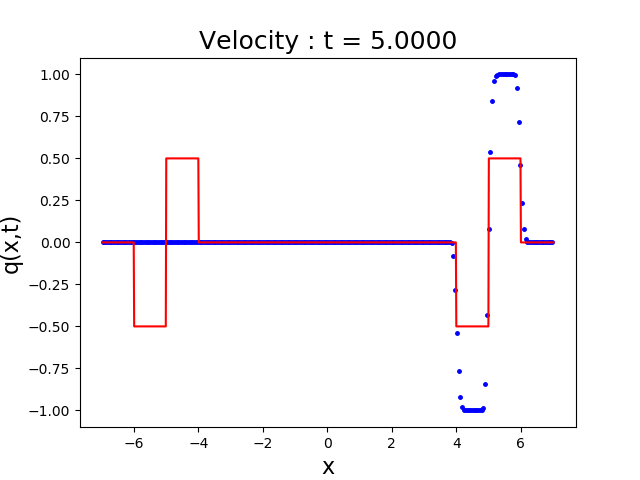

In [14]:
fig = figure(1)
clf()

mq = 1  # Component to plot (0,1,..., meqn-1)

q0 = Q[:,mq,0]
hdl, = plot(xc,q0,'b.',markersize=5)

xfe = linspace(ax,bx,1000)
xfc = xfe[:-1] + dx/2
qe = qinit(xfc,meqn)
hdl_exact, = plot(xfc,qe[:,mq],'r-')


if mq == 0:
    tstr = 'Pressure : t = {:.4f}'
else:
    tstr = 'Velocity : t = {:.4f}'

htitle = title(tstr.format(0),fontsize=18)


for i,t in enumerate(tvec):
    q = Q[:,mq,i]
    
    hdl.set_ydata(q)

    qe = qexact(xfc,t,meqn)
    hdl_exact.set_ydata(qe[:,mq])
    
    xlabel('x',fontsize=16)
    ylabel('q(x,t)',fontsize=16)
    htitle.set_text(tstr.format(t))
    
    ylim([-1.1,1.1])
    pause(0.1)

    fig.canvas.draw()        